# Notebook de prédiction

In [1]:
%%capture
#Dowload some libraries
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D
!pip install patchify
import os
import numpy as np
import h5py
import keras
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
import pandas
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [10]:
%ls /content/drive/MyDrive/Rendu_Adrien_Anisse_Antoine_Loris_Pierre/

bin@      dev/   lib32@   mnt/                      root/  sys/    var/
boot/     etc/   lib64@   NGC-DL-CONTAINER-LICENSE  run/   tmp/
content/  home/  libx32@  opt/                      sbin@  tools/
datalab/  lib@   media/   proc/                     srv/   usr/


## Import du modèle 

In [6]:
encoder_weights = 'imagenet'
BACKBONE = 'resnet50' 
preprocess_input = sm.get_preprocessing(BACKBONE)

directory = '/content/drive/MyDrive/Rendu_Adrien_Anisse_Antoine_Loris_Pierre/' ## L'endroit où vous avez mis le dossier et son nom

#Load the pretrained model for prediction
my_model = keras.models.load_model(directory + 'saved_models/OurBestModel1.h5', compile=False)

OSError: ignored

## Prédictions

In [ ]:
def predict(filename, directory = directory):
    f = h5py.File(directory + 'to_predict/' + filename, 'r')
    dset = f['raw']
    dset_label = f['label']
    data = np.array(dset[:,:,:])
    data_label = np.array(dset_label[:,:,:])
    Aneurisma_data = np.array(data).transpose(1,2,0)
    Aneurisma_label = np.array(data_label).transpose(1,2,0)
    img_patche1 = patchify(Aneurisma_data, (64, 64, 64), step=64) 
    img_patche = np.reshape(img_patche1, (-1, img_patche1.shape[3], img_patche1.shape[4], img_patche1.shape[5]))
    img_patche_before = np.stack((img_patche,)*3, axis=-1)

    lbl_patche = patchify(Aneurisma_label, (64, 64, 64), step=64) 
    lbl_patche = np.reshape(lbl_patche, (-1, lbl_patche.shape[3], lbl_patche.shape[4], lbl_patche.shape[5]))
    lbl_patche_before = np.expand_dims(lbl_patche, axis=4)

    img_patche = preprocess_input(img_patche_before)
    lbl_patche = preprocess_input(lbl_patche_before)

    #Test Time augmentation is simply to apply different transformations to test image like: rotations, flipping and etc. 
    #Then feed these different transformed images to the trained model and average the results to get more confident answer.

    # Predict each 3D patch  for rot3D
    predicted_patches_rot3D = []
    for i in range(img_patche.shape[0]):
        single_patch =  np.einsum('ijkl->ikjl',img_patche[i,:,:,:])
        single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
        single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
        single_patch_prediction=np.einsum('ikj->ijk',single_patch_prediction).astype(np.uint8)
        predicted_patches_rot3D.append(single_patch_prediction)
    predicted_patches_rot3D=np.array(predicted_patches_rot3D)

  # Predict each 3D patch
    predicted_patches_n = []
    for i in range(img_patche.shape[0]):
        single_patch = img_patche[i,:,:,:]
        single_patch_3ch_input =np.expand_dims(single_patch, 0)
        single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
        predicted_patches_n.append(single_patch_prediction)
    predicted_patches_n=np.array(predicted_patches_n)

    # Predict each 3D patch for lr
    predicted_patches_lr = []
    for i in range(img_patche.shape[0]):
        single_patch =  np.fliplr(img_patche[i,:,:,:])
        single_patch_3ch_input =np.expand_dims(single_patch, 0)
        single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
        single_patch_prediction=np.fliplr(single_patch_prediction).astype(np.uint8)
        predicted_patches_lr.append(single_patch_prediction)
    predicted_patches_lr=np.array(predicted_patches_lr)

    # # Predict each 3D patchfor ud
    # predicted_patches_ud = []
    # for i in range(img_patche.shape[0]):
    #     single_patch =  np.flipud(img_patche[i,:,:,:])
    #     single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
    #     single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    #     single_patch_prediction=np.flipud(single_patch_prediction).astype(np.uint8)
    #     predicted_patches_ud.append(single_patch_prediction)
    # predicted_patches_ud=np.array(predicted_patches_ud)

    # Predict each 3D patch  for rot90
    # predicted_patches_rot90 = []
    # for i in range(img_patche.shape[0]):
    #     single_patch =  np.rot90(img_patche[i,:,:,:])
    #     single_patch_3ch_input =np.expand_dims(single_patch, 0)
    #     single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    #     single_patch_prediction=np.rot90(single_patch_prediction, k = -1).astype(np.uint8)
    #     predicted_patches_rot90.append(single_patch_prediction)
    # predicted_patches_rot90=np.array(predicted_patches_rot90)

    
    #averaging the above predictions
    #the aggregation of predictions across transformed versions of a test input using simple average
    threshold=0.4
    prediction=(((predicted_patches_rot3D  + predicted_patches_lr + predicted_patches_n)/3)>threshold).astype(np.uint8)
    #Reshape to the shape we had after patchifying
    predicted_patches_reshaped = np.reshape(prediction, 
                                        (img_patche1.shape[0], img_patche1.shape[1], img_patche1.shape[2],
                                         img_patche1.shape[3], img_patche1.shape[4], img_patche1.shape[5]) )
    
    reconstructed_image = unpatchify(predicted_patches_reshaped, Aneurisma_data.shape)

    reconstructed_image = np.array(reconstructed_image).transpose(2,0,1)
    f = open(directory+'prediction/' + filename, 'x')
    f.close()
    hf = h5py.File(directory+'prediction/' + filename, 'w')
    hf.create_dataset('pred', data=reconstructed_image)
    hf.close()
    return reconstructed_image ## if you want to store the image in a variable 

### Boucle de prédiction 

In [ ]:
for filename in os.listdir(directory + 'to_predict/'):
    f = os.path.join(directory + 'to_predict', filename)
    # checking if it is a file
    if os.path.isfile(f):
        predict(filename)

1/1 [==============================] - 2s 2s/step


In [ ]:
directory = '/content/drive/My Drive/Challenge/Rendu_Adrien_Anisse_Antoine_Loris_Pierre/' ## L'endroit où vous avez mis le dossier et son nom
f = h5py.File(directory + 'to_predict/' + 'scan_1.h5', 'r')
dset = f['raw']
dset_label = f['label']
data = np.array(dset[:,:,:])
data_label = np.array(dset_label[:,:,:])
Aneurisma_data = np.array(data).transpose(1,2,0)
Aneurisma_label = np.array(data_label).transpose(1,2,0)

In [ ]:
f = h5py.File(directory + 'prediction/' + 'scan_1.h5', 'r')
prediction =f

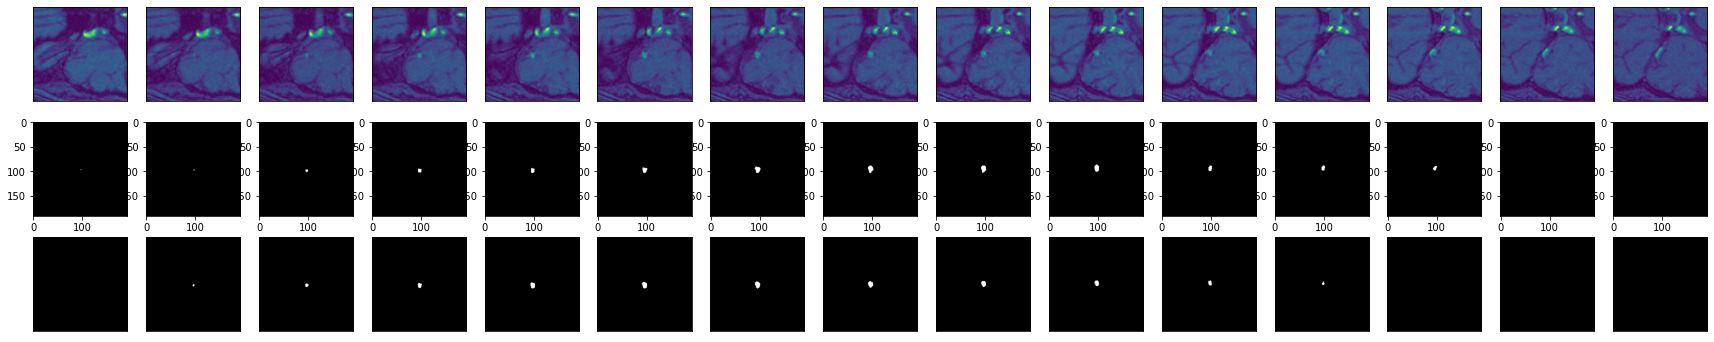

In [ ]:
# The data is displayed as sequential data sets 3D MRI data, 15 sequential slices of a 3D image
n = 15
plt.figure(figsize=(30, 6))
for i in range(24, n+24):
    # display original
    img_data = Aneurisma_data[:,:,i]
    img_label = Aneurisma_label[:,:,i]
    ax = plt.subplot(3, n, i-23)
    plt.imshow(img_data)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(3, n, i-23  + n)
    plt.imshow(,cmap='gray')
    ax = plt.subplot(3, n, i-23  + 2*n)
    plt.imshow(img_label,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()